# Ringdown fit from IMR results

We will show how to initialize a ringdown fit starting from a reference set of inspiral-merger-ringdown (IMR) parameter estimation (PE) samples, as would be produced in a regular GW analysis. This can be useful when launching a first exploratory fit for an event for which we have IMR results for some reference waveform.

<div class="alert alert-info">

Note

The [GWpy package](http://gwpy.github.io/) is only an _optional_ dependence for `ringdown`: you should install it before running this notebook (e.g., `pip install gwpy`); alternatively, you can download the data separately and load it directly from disk as in the GW150914 example.

</div>

In [ ]:
%pip install gwpy

## Preliminaries

We begin with some standard imports and global settings.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

## Set up fit and run

We will first show how straightforward it is to set-up a fit automatically from the PE samples we downloaded above, and then we will explain what happened under the hood.

To set up the fit, we will use a set of posterior samples for GW150914 obtained using the `IMRPhenomXPHM` waveform in GWTC-2.1, which we can download from Zenodo.

In [ ]:
!wget -nc https://zenodo.org/records/6513631/files/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5

Now we need only point to the file we just downloaded to create a fit automatically.

In [5]:
fit = rd.fit.Fit.from_imr_result('IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5',
                                 modes=[(1,-2,2,2,0), (1, -2,2,2,1)], cosi=-1)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

And, it's ready to run! (This might take a couple of minutes)

In [6]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

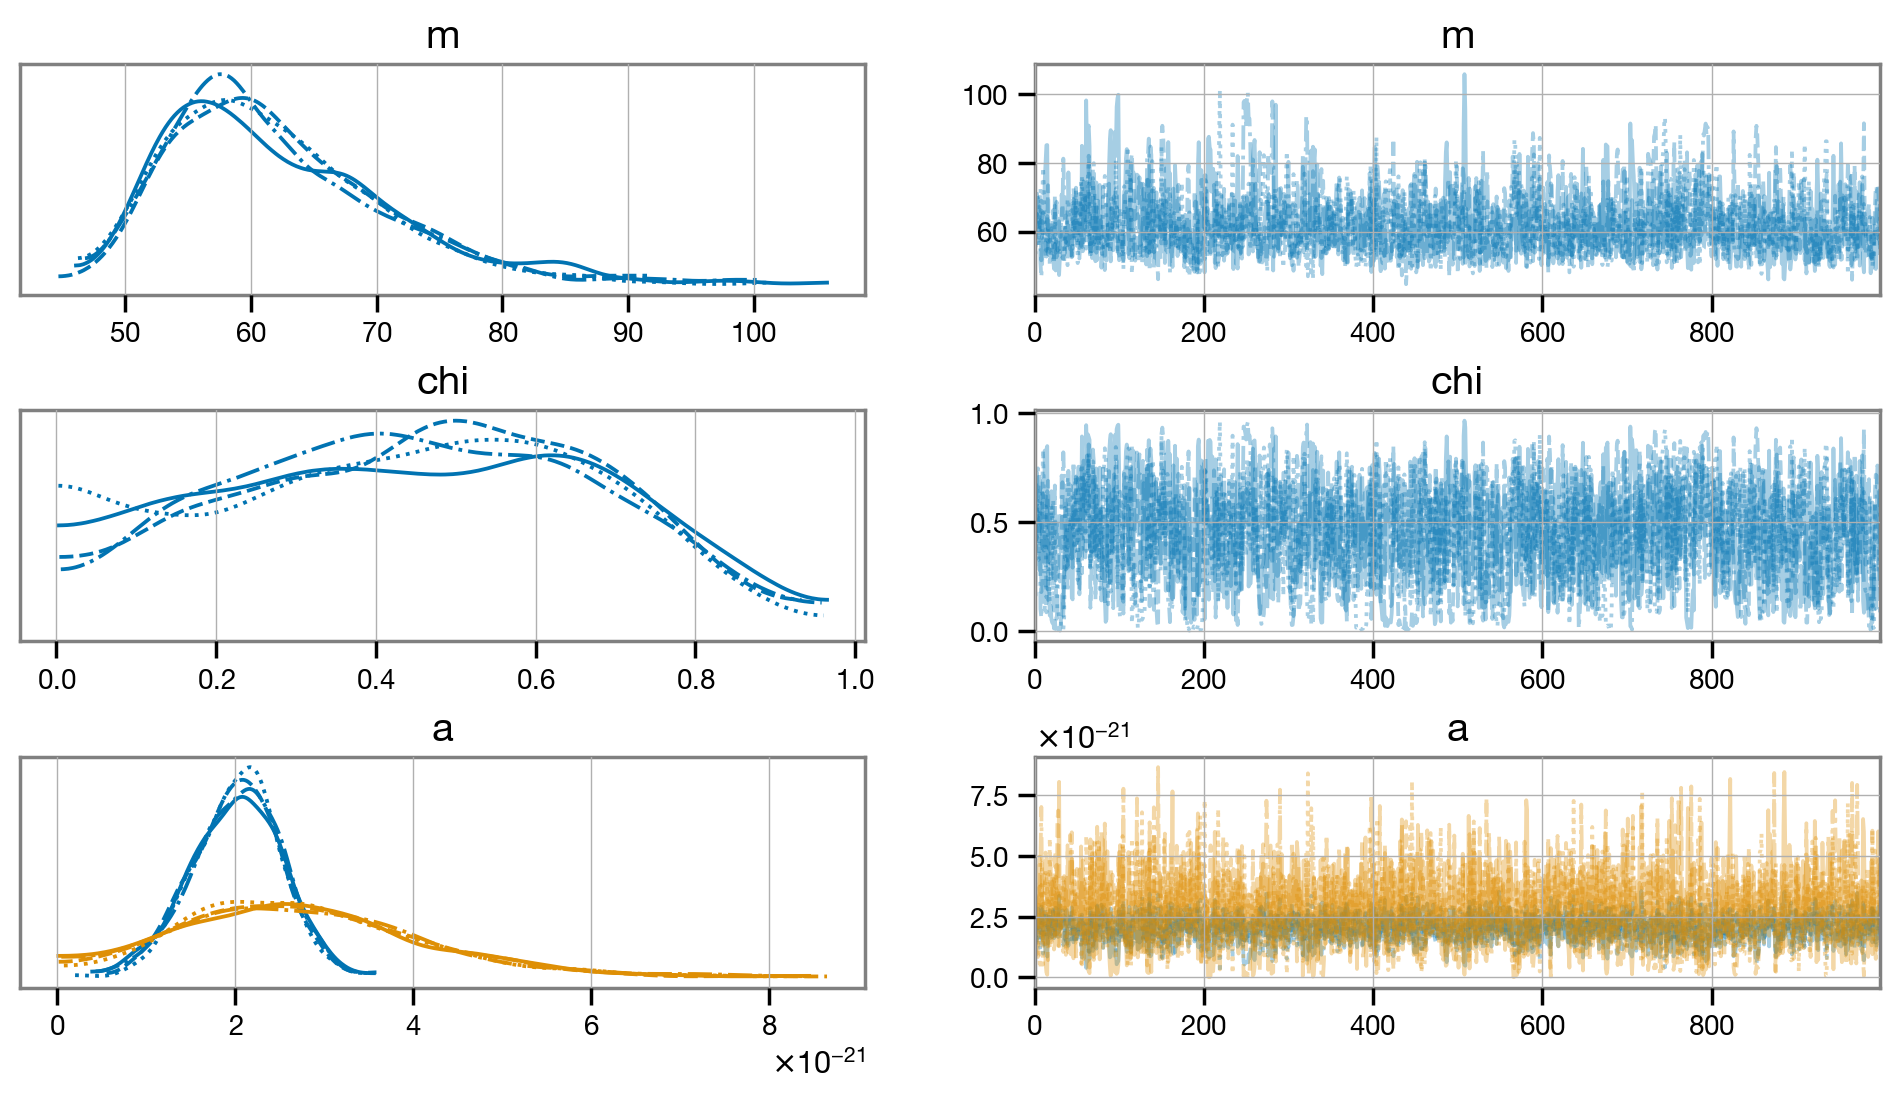

In [7]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a']);
plt.subplots_adjust(hspace=0.5)

You can export the settings to reproduce this fit later by saving them to a config file.

In [8]:
fit.to_config('config.ini');

That's it! To understand how this fit was constructed, read on.

## What just happened?

The `fit.from_imr_result` method loaded the IMR result file that we downloaded from Zenodo; together the information about the Kerr `modes` we wished to fit, as well as the inclination `cosi` we wanted to assume, `ringdown` used the IMR posterior results to initialize a fit with a best guess for the target time, analysis duration and prior ranges.

We can break down the logic that went into creating the fit above by examining the properties of the Fit. First, the IMR samples are accessible in `fit.imr_result` as an `IMRResult` object (a wrapper around a pandas `DataFrame` with some useful features).

In [9]:
fit.imr_result

,chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,theta_jn,psi,...,viewing_angle,cos_iota,tilt_1_infinity_only_prec_avg,tilt_2_infinity_only_prec_avg,spin_1z_infinity_only_prec_avg,spin_2z_infinity_only_prec_avg,chi_eff_infinity_only_prec_avg,chi_p_infinity_only_prec_avg,cos_tilt_1_infinity_only_prec_avg,cos_tilt_2_infinity_only_prec_avg
0,29.180724,0.787959,0.924210,0.331092,1.913304,1.676054,5.394340,1.210051,2.775318,1.800080,...,0.366275,-0.768574,1.794469,2.104876,-0.205001,-0.168542,-0.188934,0.901187,-0.221812,-0.509049
1,29.953047,0.864175,0.647369,0.313305,1.841044,1.839976,3.868170,0.024863,2.660558,0.757138,...,0.481035,-0.875345,2.042512,1.387529,-0.294174,0.057098,-0.131335,0.576670,-0.454415,0.182244
2,31.433890,0.852029,0.205678,0.875008,2.365895,1.369656,2.916934,5.576937,2.493798,1.272124,...,0.647795,-0.844900,2.962913,1.292919,-0.202403,0.240028,0.001138,0.700753,-0.984079,0.274315
3,30.741031,0.980341,0.711251,0.004800,1.672429,0.627161,4.591901,0.933866,2.967835,0.886179,...,0.173758,-0.943770,1.668616,1.332239,-0.069464,0.001134,-0.034515,0.707851,-0.097664,0.236301
4,31.270597,0.930130,0.250640,0.227152,1.373358,1.525285,0.643552,6.019726,3.074509,2.418739,...,0.067084,-0.993552,0.560167,2.384433,0.212334,-0.165092,0.030453,0.143627,0.847167,-0.726790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147629,29.793946,0.721785,0.694857,0.426549,1.904654,1.440450,6.218998,0.473110,2.818321,2.597370,...,0.323271,-0.857428,1.678516,1.946527,-0.074705,-0.156523,-0.109004,0.690829,-0.107511,-0.366952
147630,30.498213,0.975876,0.270623,0.135632,1.804454,2.410538,3.755427,3.016118,2.836371,1.129183,...,0.305221,-0.950458,2.159120,1.654079,-0.150187,-0.011283,-0.081583,0.225124,-0.554968,-0.083186
147631,30.140508,0.756905,0.075144,0.794470,1.825860,1.779995,5.739989,1.122504,2.895506,1.330361,...,0.246087,-0.917919,1.294716,1.847585,0.020483,-0.217103,-0.081873,0.556026,0.272587,-0.273268
147632,29.172886,0.991457,0.292899,0.712441,1.239706,2.152905,3.206772,0.291205,2.604590,2.792774,...,0.537003,-0.844222,2.891489,1.584026,-0.283786,-0.009425,-0.147194,0.705428,-0.968887,-0.013230


We will walk step-by-step through how this information is used to create a fit.

### Fetching data

A lot of information about the IMR run is contained in the configuration file that usually ships with PE files produced by [pesummary](http://pesummary.readthedocs.io/). This includes data information like origin, trigger time, segment length and sampling rate.

The config file is loaded and stored in the `IMRResult` object:

In [10]:
fit.imr_result.config.keys()

dict_keys(['accounting', 'calibration-model', 'catch-waveform-errors', 'channel-dict', 'coherence-test', 'convert-to-flat-in-component-mass', 'create-plots', 'create-summary', 'data-dict', 'data-format', 'deltaT', 'detectors', 'distance-marginalization', 'distance-marginalization-lookup-table', 'duration', 'email', 'existing-dir', 'extra-likelihood-kwargs', 'frequency-domain-source-model', 'gaussian-noise', 'generation-seed', 'gps-file', 'gps-tuple', 'ignore-gwpy-data-quality-check', 'injection', 'injection-dict', 'injection-file', 'injection-numbers', 'injection-waveform-approximant', 'jitter-time', 'label', 'likelihood-type', 'local', 'local-generation', 'local-plot', 'log-directory', 'maximum-frequency', 'minimum-frequency', 'n-parallel', 'n-simulation', 'online-pe', 'osg', 'outdir', 'periodic-restart-time', 'phase-marginalization', 'plot-calibration', 'plot-corner', 'plot-format', 'plot-marginal', 'plot-skymap', 'plot-waveform', 'pn-amplitude-order', 'pn-phase-order', 'pn-spin-orde

This information can be used to read or fetch the analysis data. If a file data path is found in the config and the file exists, it will be loaded from disk; otherwise, `GWpy` is used to fetch data based on the trigger time and segment length info.

_NOTE:_ `GWpy` is an optional dependence of `ringdown`, but it is required to use this functionality.

In [11]:
fit.imr_result.data_options

{'t0': 1126259462.391,
 'ifos': ['H1', 'L1'],
 'seglen': 4.0,
 'sample_rate': 16384,
 'channel': 'gwosc'}

Data retrieval options can be updated through the `data_kws` argument of `fit.from_imr_result`.

### ACFs from PSDs

PE sample files released by the LIGO-Virgo-KAGRA collaborations typically contain the noise power spectral density (PSD) used in the analysis that produced the samples; that can be used to derive a time-domain autocovariance function (ACF) for the ringdown analysis. With some automatic padding, this is how `ringdown` derived the ACFs for the analyses above.

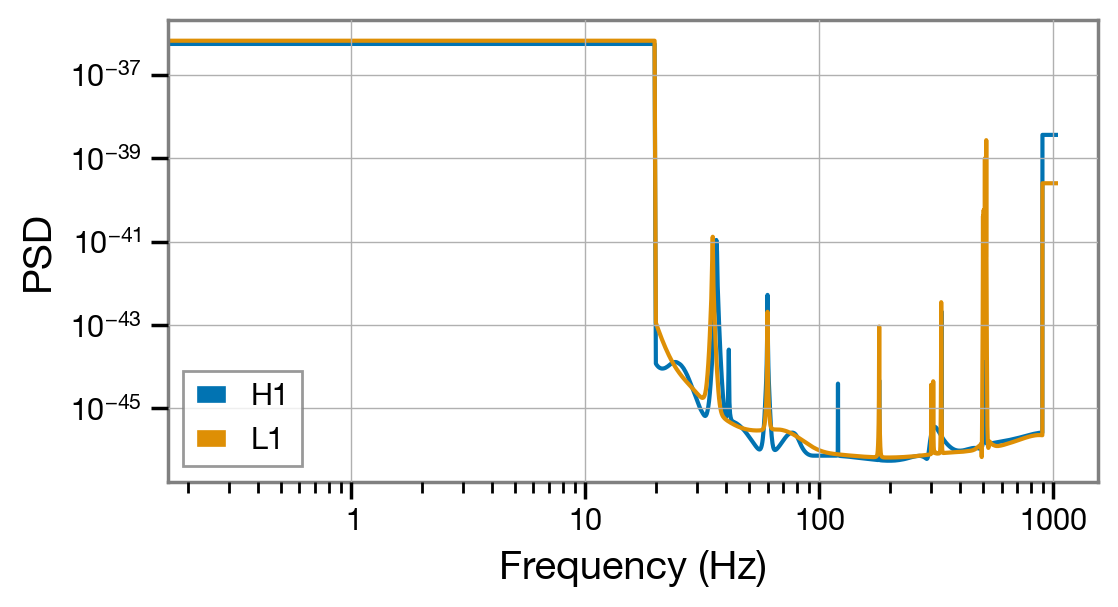

In [12]:
plt.figure(figsize=(6, 3))
for ifo, acf in fit.acfs.items():
    plt.loglog(acf.to_psd(), label=ifo)
plt.legend(loc='lower left')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD');

<div class="alert alert-info">

Note

Not all IMR results files contain PSDs; if you know what PSDs were used for the analysis, you can provide them to `Fit.from_imr_result` by passing a dictionary indexed by IFOs through the `psds` argument.

</div>

### Target time

The fit target was automatically specified from the posterior samples:

In [13]:
fit.target

SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 407382011), ra=2.3740998909517543, dec=-1.182031580667859, psi=0.7455033030298557, duration=0.2578125)

By default, the start time of the ringdown fit is set by:
1. identifying the interferometer in which the the signal arrival time is best determined,
2. taking the median of an estimate of the strain _peak time_ at the best measured detector,
3. identifying the posterior sample closest to the chosen reference time and using it to set the sky location.

You can reproduce these steps by calling `get_best_peak_times`.

In [14]:
best_peak_times, reference_ifo = fit.imr_result.get_best_peak_times()
best_peak_times.head().map("{:.6f}".format), reference_ifo

(H1    1126259462.423906
 L1    1126259462.416856
 Name: 8183, dtype: object,
 'H1')

In [15]:
fit.start_times

{'H1': 1126259462.4239063, 'L1': 1126259462.4168558}

We can visualize that by comparing the fit start times to the time posteriors in the IMR result.

In [16]:
peak_times = fit.imr_result.get_peak_times()
peak_times.head().style.format("{:.6f}")

,H1,L1
0,1126259462.424527,1126259462.417663
1,1126259462.423675,1126259462.416752
2,1126259462.423441,1126259462.416438
3,1126259462.424386,1126259462.417212
4,1126259462.423912,1126259462.416951


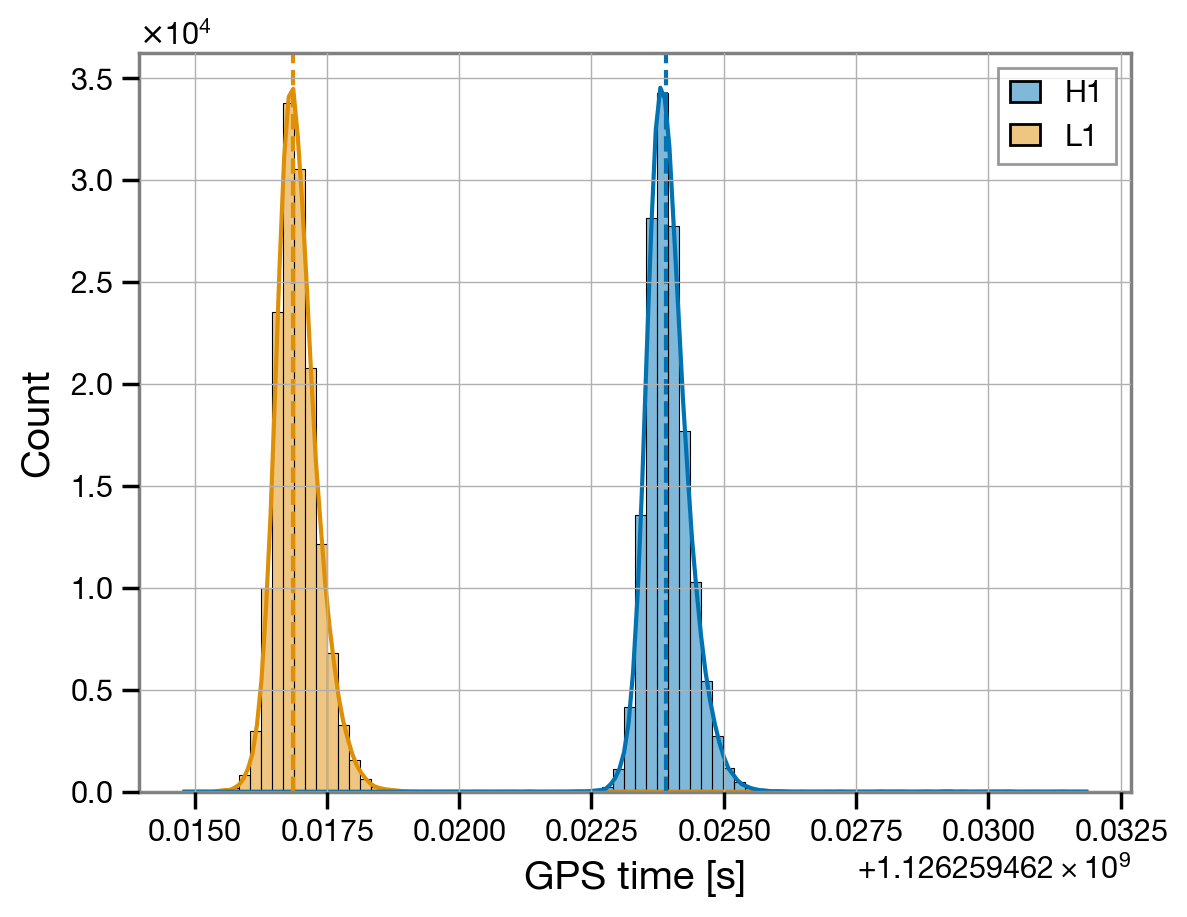

In [17]:
sns.histplot(peak_times, kde=True)
plt.axvline(fit.start_times['H1'], ls='--')
plt.axvline(fit.start_times['L1'], ls='--', c='C1')
plt.xlabel('GPS time [s]');

In [18]:
fit.imr_result.get_best_peak_target()

SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 407382011), ra=2.3740998909517543, dec=-1.182031580667859, psi=0.7455033030298557, duration=0.0)

<div class="alert alert-info">

Note

By default, the proxy for the _peak time_ is taken to be the coalescence time found in the IMR posterior samples; for some approximants you can ask `ringdown` to itself compute a posterior on the actual waveform peak time by passing `manual=True` to `get_peak_times`, or equivalently `peak_kws={'manual': True}` to `Fit.from_imr_result`.

</div>

### Duration

The segment duration for the ringdown analysis is chosen by computing the signal-to-noise ratio (SNR) that IMR templates accumulate after the analysis start time and requiring that this stabilizes:

For a number of draws from the IMR posterior samples, `ringdown` reconstructs the corresponding waveforms, and computes their optimal SNR integrating from the fit start time to some duration set as an initial guess; the duration is doubled until the median cumulative SNR at halfway through the segment is within 10% of the the SNR accumulated by the end of the segment.

We can plot the cumulative post-peak SNR accumulated by the IMR waveform easily using `fit.compute_imr_snrs`

In [19]:
snrs = fit.compute_imr_snrs(optimal=True, cumulative=True, network=True, nsamp=100)
snrs.shape

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

(528, 100)

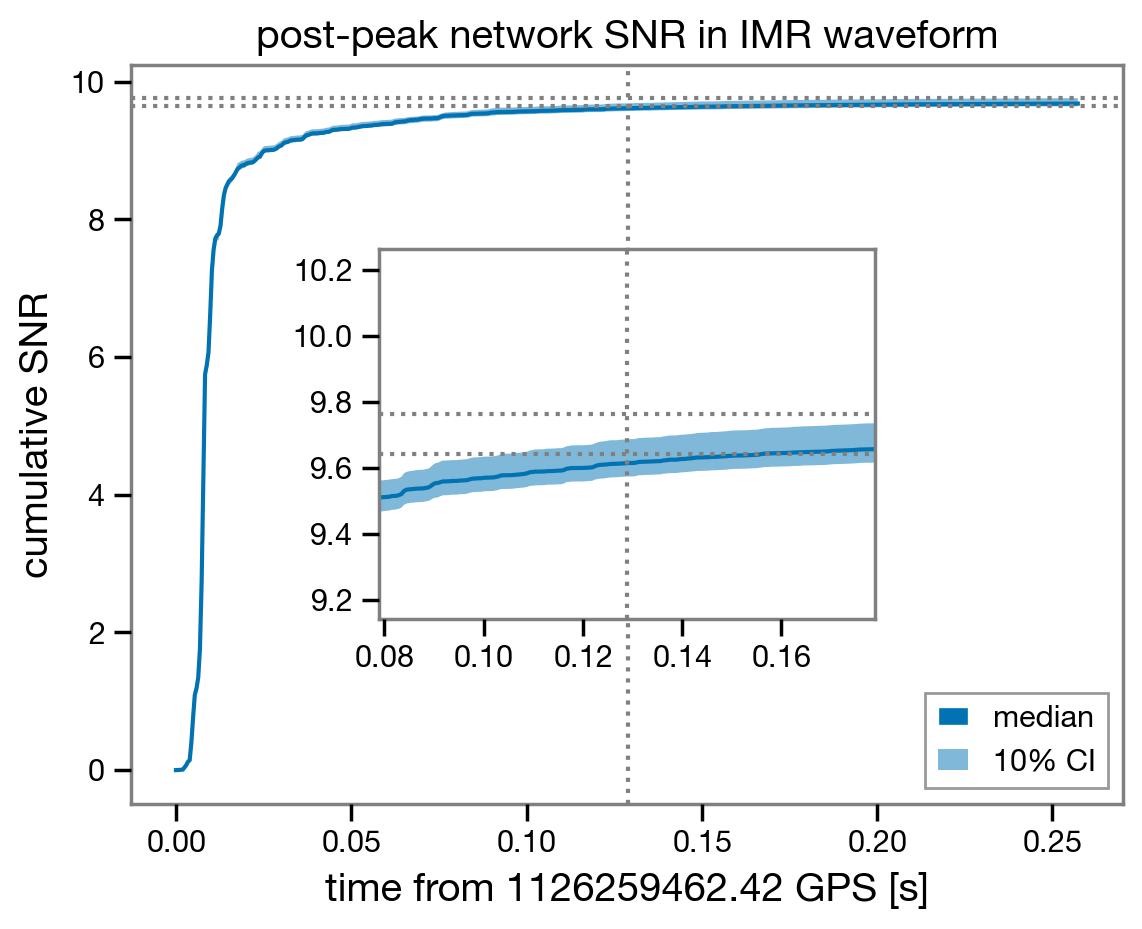

In [20]:
# Create an inset zoomed into the intersection area
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()
inset = inset_axes(ax, width="50%", height="50%", loc="center")

t  = fit.analysis_times['H1'] - fit.start_times['H1']
l, m, h = np.quantile(snrs, [0.45, 0.5, 0.55], axis=1)

for a in [ax, inset]:
    a.plot(t, m, label='median')
    a.fill_between(t, l, h, alpha=0.5, label='10% CI')
    a.axvline(fit.duration / 2, ls=':', c='gray')
    a.axhline(h[-1], ls=':', c='gray')
    a.axhline(l[-1], ls=':', c='gray')
ax.set_xlabel(f'time from {fit.start_times["H1"]:.2f} GPS [s]')
ax.set_ylabel('cumulative SNR')
ax.set_title('post-peak network SNR in IMR waveform')

ax.legend()

ax.grid(False)
inset.grid(False)

# Set limits for the inset to focus on the intersection region
inset.set_xlim(fit.duration / 2 - 0.05, fit.duration / 2 + 0.05)
inset.set_ylim(l[-1] - 0.5, h[-1] + 0.5);

### Prior settings

Finally, `ringdown` estimated some reasonable prior settings based on the model information we provided (the Kerr modes and the inclination prior).

In [21]:
fit.model_settings

{'cosi': -1,
 'a_scale_max': 4.112310204704793e-20,
 'm_max': 120.0,
 'm_min': 33.0}

The amplitude scale is set based on the value of the IMR waveform at the start time. The mass prior is set based on the remnant mass estimated in the IMR results.

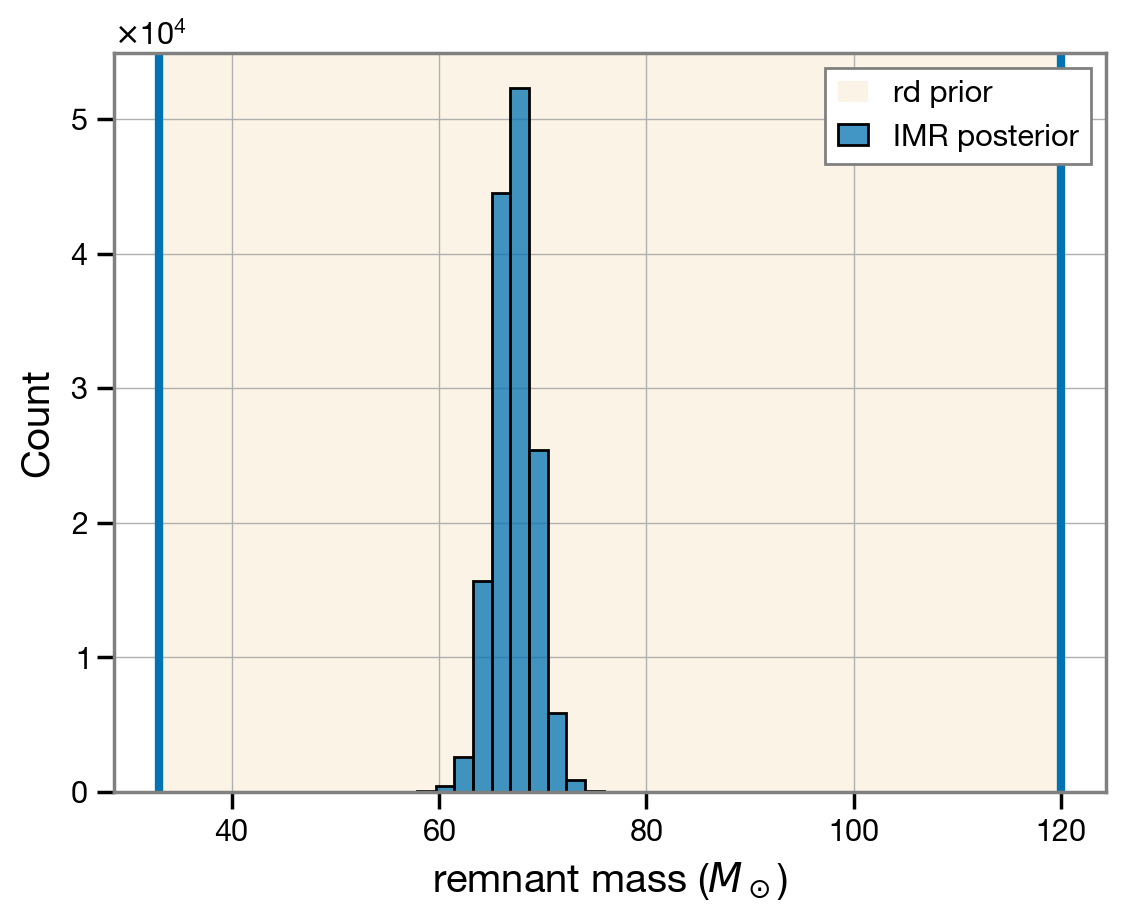

In [22]:
sns.histplot(fit.imr_result.remnant_mass_scale, bins=10, label='IMR posterior')
plt.axvline(fit.model_settings['m_max'], lw=3)
plt.axvline(fit.model_settings['m_min'], lw=3);

yl = plt.gca().get_ylim()
plt.fill_betweenx(yl, fit.model_settings['m_min'], fit.model_settings['m_max'], alpha=0.1, zorder=-1, label='rd prior')
plt.ylim(yl)
# send gridlines to back
plt.gca().set_axisbelow(True)
plt.legend(framealpha=1)
plt.xlabel(r"remnant mass ($M_\odot$)");

Of course, you can update any of the model settings as you wish before running.